# Getting the rating from the reviews

In [1]:
!pip install -q --disable-pip-version-check -r ../requirements.txt

In [67]:
# Matrix operations
import numpy as np

# Dataframes
import pandas as pd

# Charts
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

# SciKit Learn Utilities
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import OneHotEncoder
from sklearn.decomposition import TruncatedSVD
from sklearn.manifold import TSNE
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# Horizontal stack in a less memory consuming approach
from scipy.sparse import hstack

# To perform Oversampling
import nlpaug.augmenter.word as naw

# Progress bar
from tqdm import tqdm

# PyTorch Dataset
import torch
from torch.utils.data import DataLoader, Dataset, random_split

# PyTorch Lightning NN Architecture
import pytorch_lightning as pl
import torch.nn.functional as F
from pytorch_lightning import Trainer

# PyTorch Lightning Callbacks
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.callbacks import EarlyStopping
from pytorch_lightning.callbacks import LearningRateMonitor

## GPU check

In [68]:
# Check for CUDA support
print("CUDA is available:", torch.cuda.is_available())

# Number of GPUs available
print("Number of GPUs:", torch.cuda.device_count())

# Current GPU
if torch.cuda.is_available():
    print("Current GPU:", torch.cuda.current_device())

    # GPU Name
    print("GPU Name:", torch.cuda.get_device_name(torch.cuda.current_device()))

CUDA is available: True
Number of GPUs: 1
Current GPU: 0
GPU Name: NVIDIA GeForce RTX 3090


## Preprocessing

### 1. Displaying the data

In [69]:
reviews_df = pd.read_csv('../data/Big_AHR.csv', index_col=0)
reviews_df.head()

,title,rating,review_text,location,hotel,label
0,Excelente y personal amable,5,Un hotel muy bueno. El personal fue muy amabl...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
1,Céntrico,4,"Muy buen hotel al nivel de lo esperado, habita...",Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
2,Hotel excepcional,5,Magnífico hotel. La verdad es que todo perfect...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
3,WOW!!,5,"Hotel hermoso, buen diseño, original, limpio. ...",Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1
4,Magnifico,5,Magnífica ubicación en pleno centro de Sevilla...,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,1


Obtain an example from the dataset:

In [70]:
def get_one_sample_with_columns(df, id=0):
    return list(zip(list(df.columns), list(df.iloc[id])))

Display the rating and the sentiment associated to the review:

In [71]:
def display_ratings(df):
    rating = df['rating'].value_counts()

    fig = px.bar(
        x=rating.index,
        y=rating.values,
        labels={'x': 'Rating', 'y': 'Count'},
        title='Count of Each Unique Rating'
    )

    fig.show()

In [72]:
def display_review_sentiment(df):
    SENTIMENT_CONVERSION = { 0: "Negative", 1: "Positive", 3: "Neutral" }

    sentiment_column = df['label'].value_counts().sort_index()

    fig = px.bar(
        # Convert numerical x-axis labels to string labels
        x=[SENTIMENT_CONVERSION[label] for label in sentiment_column.index],
        y=sentiment_column.values,
        labels={'x': 'Sentiment', 'y': 'Count'},
        title='Count of Each Unique Sentiment'
    )

    fig.show()

In [73]:
display_ratings(reviews_df)

In [74]:
display_review_sentiment(reviews_df)

As we can see, the dataset is completely unbalanced. There are almost 10x of 5-star ratings that 2-star ratings.

### 2. Combining the text features

Combining the title and the review_text attributes offer several advantages:

1. Contextual Information: Titles often provide a summary or highlight of the most important aspect of the review. We suspect that combining it with the review text can give the model more context, which might improve its understanding of the review sentiment.

2. Reducing Sparsity: We'll convert the text data into high-dimensional sparse vectors (e.g., via TF-IDF). If each text feature ('title' and 'review_text') is sparse and has little data, combining them can result in a less sparse representation, making it easier for the model to find patterns.

3. Noise Reduction: If one of the text features is noisy or less reliable, combining it with a more informative feature can help "average out" the noise, leading to a more robust representation.

In [75]:
if 'title' in reviews_df.columns.to_list() or 'review_text' in reviews_df.columns.to_list():
    reviews_df['text_content'] = reviews_df['title'] + ' ' + reviews_df['review_text']
    reviews_df = reviews_df.drop(columns=['title', 'review_text'])

Reorder the columns just to improve its readability:

In [76]:
new_column_order = ['location', 'hotel', 'text_content', 'label', 'rating']
reviews_df = reviews_df[new_column_order]

In [77]:
reviews_df.head()

,location,hotel,text_content,label,rating
0,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,Excelente y personal amable Un hotel muy bueno...,1,5
1,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,Céntrico Muy buen hotel al nivel de lo esperad...,1,4
2,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,Hotel excepcional Magnífico hotel. La verdad e...,1,5
3,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,"WOW!! Hotel hermoso, buen diseño, original, li...",1,5
4,Seville_Province_of_Seville_Andalucia,H10_Casa_de_la_Plata,Magnifico Magnífica ubicación en pleno centro ...,1,5


### 3. Removing NaN and missing values

In [78]:
def has_nan_or_missing_values(df):
    # Check for NaN values
    nan_check = df.isna().any()

    # Check for empty values (assuming empty strings)
    empty_check = (df == '').any()

    # Combine the results to check for both NaN and empty values
    has_nan_or_empty = nan_check | empty_check

    print(has_nan_or_empty)
    print(f"Number of samples: {df.shape[0]}")

In [79]:
has_nan_or_missing_values(reviews_df)

location         True
hotel            True
text_content    False
label           False
rating          False
dtype: bool
Number of samples: 18172


In [80]:
pd.unique(reviews_df['location'])[-5:]

array(['anlucar_de_Barrameda_Province_of_Cadiz_Andalucia',
       'Alajar_Sierra_de_Aracena_and_Picos_de_Aroche_Natural_Park_Pro',
       'Alajar_Sierra_de_Aracena_and_Picos_de_Aroche_Natural_Park_Province_of',
       'Tavira_Faro_District_Algarve', nan], dtype=object)

As we can see, there's a NaN so we'll remove it:

In [81]:
reviews_df = reviews_df.dropna(subset=['location'])

In [82]:
has_nan_or_missing_values(reviews_df)

location        False
hotel           False
text_content    False
label           False
rating          False
dtype: bool
Number of samples: 16356


✅ Removing the NaN values resulted on also removing the NaN and missing values from the hotel attribute.

In [83]:
get_one_sample_with_columns(reviews_df)

[('location', 'Seville_Province_of_Seville_Andalucia'),
 ('hotel', 'H10_Casa_de_la_Plata'),
 ('text_content',
  'Excelente y personal amable Un hotel muy bueno.  El personal fue muy amable y profesional. Nos gustaban desayuno mucho también. El habitación cómoda y limpia. Volvimos a próxima vez en Seville por seguro. Lo recomiendo !! Y también ubicación muy cerca del centro :))))'),
 ('label', 1),
 ('rating', 5)]

Obtain more information about the dataframe:

In [84]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16356 entries, 0 to 16355
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   location      16356 non-null  object
 1   hotel         16356 non-null  object
 2   text_content  16356 non-null  object
 3   label         16356 non-null  int64 
 4   rating        16356 non-null  int64 
dtypes: int64(2), object(3)
memory usage: 766.7+ KB


Just for efficiency purposes, we can change the type of the label and rating columns:

In [85]:
reviews_df = reviews_df.astype({'label': 'uint8', 'rating': 'uint8'})

In [86]:
reviews_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 16356 entries, 0 to 16355
Data columns (total 5 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   location      16356 non-null  object
 1   hotel         16356 non-null  object
 2   text_content  16356 non-null  object
 3   label         16356 non-null  uint8 
 4   rating        16356 non-null  uint8 
dtypes: object(3), uint8(2)
memory usage: 543.1+ KB


### 4. Balance the data

In [22]:
import nltk
from nltk.corpus import wordnet  # Make sure to import wordnet

# Download wordnet package if you haven't
nltk.download('wordnet')

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aaron\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

We'll perform text oversampling in order to avoid overfitting while balancing the dataset.

For that, we'll use the library nlpaug which will allow us to perform text augmentation by using synonyms.

In [23]:
aug = naw.SynonymAug(aug_src='wordnet', lang='spa', aug_max=100)

def augment_text(text):
    return aug.augment(text)[0]

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Aaron\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Aaron\AppData\Roaming\nltk_data...


In [24]:
def oversample(reviews_df, target_samples):
    new_reviews = []

    for rating, target_count in tqdm(target_samples.items(), desc='Oversampling Ratings', unit='rating', total=len(target_samples)):
        # Filter reviews with the current rating
        ratings = reviews_df[reviews_df['rating'] == rating] 

        if target_count > len(ratings):
            # Number of samples to generate
            oversample_count = target_count - len(ratings)
            
            for _ in range(oversample_count):
                # Randomly select a review to augment
                row = ratings.sample(1).iloc[0]
                
                augmented_text = augment_text(row['text_content'])
                
                new_reviews.append({'location': row['location'],
                                    'hotel': row['hotel'],
                                    'text_content': augmented_text,
                                    'label': row['label'],
                                    'rating': rating})

    return pd.DataFrame(new_reviews)

In [25]:
max_rating_samples = max([len(reviews_df[reviews_df['rating'] == rating]) for rating in [1,2,3,4,5]])
print(f"Maximum number of samples in a rating: {max_rating_samples}")

Maximum number of samples in a rating: 8474


In [26]:
target_samples = {1: max_rating_samples, 2: max_rating_samples, 3: max_rating_samples, 4: max_rating_samples, 5: max_rating_samples}
new_df = oversample(reviews_df, target_samples)

Oversampling Ratings:   0%|          | 0/5 [00:00<?, ?rating/s][nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\Aaron\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping taggers\averaged_perceptron_tagger.zip.
Oversampling Ratings: 100%|██████████| 5/5 [01:29<00:00, 17.82s/rating]


In [27]:
new_df

,location,hotel,text_content,label,rating
0,Seville_Province_of_Seville_Andalucia,Hotel_Gines,Responsabilidad donde te metes Nos mandaron ha...,0,1
1,Jaen_Province_of_Jaen_Andalucia,Martin_Hostal,Un desastre Llegamos a las 13: 40 horas cargad...,0,1
2,Seville_Province_of_Seville_Andalucia,Pension_Nuevo_Pino,Horroroso La ventana del balcón no cerraba bie...,0,1
3,Seville_Province_of_Seville_Andalucia,Arc_House,Decepción absoluta Lo primero de todo es que p...,0,1
4,Granada_Province_of_Granada_Andalucia,Urban_Vida_Granada_Catedral,ESTAFADORES Urban vida Granada trabaja con ONE...,0,1
...,...,...,...,...,...
26009,Granada_Province_of_Granada_Andalucia,Hotel_Universal,Hotel sencillo pero correcto Un buen tres estr...,1,4
26010,Seville_Province_of_Seville_Andalucia,Las_Casas_de_la_Juderia,Hotel céntrico y original Estuvimos una noche ...,1,4
26011,Malaga_Costa_del_Sol_Province_of_Malaga_Andalucia,Novotel_Suites_Malaga_Centro,"Buena estancia Buena habitación, particular mu...",1,4
26012,Malaga_Costa_del_Sol_Province_of_Malaga_Andalucia,Feel_Hostels_Soho_Malaga,"una semana de vacaciones todo bien y limpio, c...",1,4


Append augmented data to the original dataframe

In [28]:
reviews_df = pd.concat([reviews_df, new_df], axis=0)

Shuffle the data:

In [29]:
reviews_df = shuffle(reviews_df).reset_index(drop=True)

As we can see, now the dataset are more balanced:

In [30]:
display_ratings(reviews_df)

In [31]:
display_review_sentiment(reviews_df)

### 5. Save balanced dataset

In [32]:
reviews_df.to_csv('../data/Big_AHR_Balanced.csv')

If the reviews_df is not defined (in case we jump directly to point 5), import it:

In [33]:
if not 'reviews_df' in locals():
    reviews_df = pd.read_csv('Big_AHR_Balanced.csv', index_col=0)

### 6. Convert categorical data into numerical format using One-Hot Encoding

We have to convert the location and hotel to numerical format using One-Hot Encoding:

In [396]:
encoder = OneHotEncoder(sparse=False)
categorical_features = encoder.fit_transform(reviews_df[['location', 'hotel']])

c:\Users\Aaron\Documents\github\review2rating\venv\Lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning:

`sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.



### 7. Convert the text data into numerical format using TF-IDF

We've to convert the text data (which is the attribute text_content) into a numerical format so it could be used by the neural network. In order to do this, we'll use TF-IDF (Term Frequency - Inverse Document Frequency), which is a technique to quantify words in a set of documents:

In [460]:
tfidf_vectorizer = TfidfVectorizer(max_features=2000)
# tfidf_vectorizer = TfidfVectorizer(ngram_range=(1, 2), max_features=2000)
text_features = tfidf_vectorizer.fit_transform(reviews_df['text_content'])

In [440]:
print(f"Number of samples: {len(text_features.toarray())}")

Number of samples: 16356


### 8. Join the one-hot-encoded data and the text in numerical format

In [441]:
combined_features = hstack([categorical_features, text_features]).tocsr()

### 9. Visualize the features using T-SNE by applying Dimensionality Reduction (Optional)

In [234]:
# Dimensionality reduction to improve the visualization
# - We're reducing to 50 components as an example, but this can be changed
svd = TruncatedSVD(n_components=50)
reduced_features = svd.fit_transform(combined_features)

Apply T-SNE (this lasts like 5min):

In [235]:
tsne = TSNE(n_components=2, random_state=42)
tsne_results = tsne.fit_transform(reduced_features)

In [236]:
# Create a DataFrame for the t-SNE results
tsne_df = pd.DataFrame(data={
    'X': tsne_results[:, 0],
    'Y': tsne_results[:, 1],
    'Rating': reviews_df['rating'],
    'Label': reviews_df['label']
})

# Plot using Plotly with Rating as color and Label as marker style
fig = px.scatter(tsne_df, x='X', y='Y', color='Rating', symbol='Label', 
                 color_continuous_scale='viridis', 
                 title="t-SNE Visualization of Reviews",
                 symbol_map={0: 'circle', 1: 'square', 3: 'cross'}
                )

# Adjust the order of the legends
fig.update_layout(coloraxis_colorbar=dict(title='Rating'))
fig.update_xaxes(title_text='t-SNE Component 1')
fig.update_yaxes(title_text='t-SNE Component 2')
fig.show()


### 10. Split the data

Convert the join features into just one dataframe:

In [442]:
# text_content, hotel, location
curated_reviews_df = pd.DataFrame(combined_features.toarray())

⚠️ Only execute the cells from the section 10.1 or 10.2, not both.

#### 10.1. Predict the label

In [122]:
X = curated_reviews_df
# convert all the values of the label column that have a value of 3 to 2
y = reviews_df['label'].replace(3, 2)

In [123]:
# Split the data into train, validation, and test set (e.g., 80%, 10%, 10%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)

#### 10.2. Predict the rating

Split the data into train and test:

In [443]:
X = curated_reviews_df
y = reviews_df['rating']

In [444]:
# Split the data into train, validation, and test set (e.g., 80%, 10%, 10%)
X_temp, X_test, y_temp, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=1/9, random_state=42)

As we can see, now we have:

- Training: X_train, y_train.

- Validation: X_val, y_val.

- Testing: X_test, y_test.

Finally, keep in mind that the PyTorch model will work with values in a range starting from 0. Therefore, we have to convert the range of the y values from 1-5 to 0-4:

In [445]:
y_train = y_train - 1
y_val = y_val - 1
y_test = y_test - 1

## Model

In [446]:
BATCH_SIZE = 32
NUM_EPOCHS = 50

Make the code more reproducible:

In [447]:
torch.manual_seed(23)  

### 1. Define a PyTorch dataset and dataloader

In [448]:
class ReviewsDataset(Dataset):
    def __init__(self, features, labels):
        self.features = features
        self.labels = labels
    
    def __len__(self):
        return len(self.features)
    
    def __getitem__(self, idx):
        return self.features[idx], self.labels[idx]

In [449]:
train_dataset = ReviewsDataset(torch.tensor(X_train.values).float(), torch.tensor(y_train.values).long())
val_dataset = ReviewsDataset(torch.tensor(X_val.values).float(), torch.tensor(y_val.values).long())
test_dataset = ReviewsDataset(torch.tensor(X_test.values).float(), torch.tensor(y_test.values).long())

In [450]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

### 2. Neural Network Architecture using PyTorch Lightning

In [451]:
class ReviewClassifier(pl.LightningModule):
    def __init__(self, layers):
        super(ReviewClassifier, self).__init__()
        self.layers = layers
        self.network = torch.nn.Sequential(*self.layers)

        # Trackers for our desired metrics
        self.train_losses = []
        self.val_losses = []
        self.val_accs = []
        self.training_step_outputs = []
        self.validation_step_outputs = []
        self.accuracy_outputs = []
    
    def forward(self, x):
        return self.network(x)
    
    def training_step(self, batch, batch_idx):
        # Obtaining the x and y value of a batch from the dataset with size BATCH_SIZE
        x, y = batch
        # Predict the value of y using x
        y_hat = self(x)

        # Loss Function: We'll use the Cross-Entropy Loss as it's a loss function used for multi-class
        # classification problems (thanks to using the softmax activation function)
        loss = F.cross_entropy(y_hat, y)
        self.training_step_outputs.append(loss)

        return loss

    def on_train_epoch_end(self, *args, **kwargs):
        # Compute the average training loss over the epoch and add it to the list of losses
        avg_train_loss = torch.stack(self.training_step_outputs).mean()
        self.training_step_outputs.clear()
        self.train_losses.append(avg_train_loss)
    
    def on_validation_epoch_end(self):
        avg_val_loss = torch.stack(self.validation_step_outputs).mean()
        avg_acc = sum(self.accuracy_outputs) / len(self.accuracy_outputs)
        self.validation_step_outputs.clear()
        self.accuracy_outputs.clear()
        
        self.val_losses.append(avg_val_loss)
        self.val_accs.append(avg_acc)
        
        metrics = {'val_loss': avg_val_loss, 'val_acc': avg_acc}
        return {'val_loss': avg_val_loss, 'progress_bar': metrics}

    def validation_step(self, batch, batch_idx):
        x, y = batch
        y_hat = self(x)
        val_loss = F.cross_entropy(y_hat, y)
        self.validation_step_outputs.append(val_loss)
        # We'll use the accuracy as the metric for the classification problem
        # - pred_val = torch.argmax in dim=1 (y-axis): [[0.1, 0.8, 0.1], 
        #                                               [0.7, 0.1, 0.2]] -> output: [1, 0]
        # - v = torch.sum(pred_val == [1, 1]) -> output: sum([True, False]) -> output: 1 (.item() gets the val)
        # - v / [1, 1].shape[0] -> output: 1 / 2 -> 50% of accuracy
        val_acc = torch.sum(torch.argmax(y_hat, dim=1) == y).item() / y.shape[0]
        self.accuracy_outputs.append(val_acc)

        self.log('val_loss', val_loss)
        self.log('val_acc', val_acc)

        return {'val_loss': val_loss, 'val_acc': val_acc}
    
    def configure_optimizers(self):
        # We'll use Adam as the optimizer as it has shown pretty good results in a lot of
        # tasks where classification is performed
        optimizer = torch.optim.Adam(
            self.parameters(),
            lr=0.001,
            weight_decay=1e-5 # L2 Regularization to prevent overfitting
        )

        # ReduceLROnPlateau: Reduce learning rate when a metric has stopped improving
        # - mode: 'min' if the metric is the loss, 'max' if the metric is accuracy
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'max')
        return {
            'optimizer': optimizer,
            'lr_scheduler': {
                'scheduler': scheduler,
                'monitor': 'val_loss',
            },
        }

In [452]:
input_dim = X_train.shape[1]
output_dim = y_train.nunique()

print(f"Input dimension: {input_dim} (input neurons)\nOutput dimension: {output_dim} (num of different ratings)")

Input dimension: 1748 (input neurons)
Output dimension: 5 (num of different ratings)


In [453]:
layers1 = [
    torch.nn.Linear(input_dim, 1024),
    torch.nn.ReLU(),
    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Linear(128, output_dim)
]

layers2 = [
    torch.nn.Linear(input_dim, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    
    torch.nn.Linear(128, output_dim)
]

layers3 = [
    torch.nn.Linear(input_dim, 2048),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),

    torch.nn.Linear(2048, 1024),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),

    torch.nn.Linear(1024, 512),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    
    torch.nn.Linear(512, 256),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    
    torch.nn.Linear(256, 128),
    torch.nn.ReLU(),
    torch.nn.Dropout(0.5),
    
    torch.nn.Linear(128, output_dim)
]

In [454]:
model = ReviewClassifier(layers2)

### 3. Training the model

Save the model every 5 epochs:

In [455]:
checkpoint_callback = ModelCheckpoint(
    filename='models/review_classifier_{epoch:02d}_{val_acc:.2f}',
    save_top_k=1,  # Save only the best model
    save_last=True,  # Save the model from the last epoch
    verbose=True,  # Print a message whenever a new top model is found
    monitor='val_acc',  # Decide what metric to monitor for model saving
    mode='max',  # Best model will be the one with the greatest 'val_acc'
    every_n_epochs=5  # Save a checkpoint every 5 epochs
)

Apply Early Stopping if it's not improving the validation loss:

In [456]:
early_stop_callback = EarlyStopping(
    monitor='val_acc',
    patience=3,  # Number of epochs with no improvement after which training will be stopped
    verbose=True,
    mode='max'  # 'max' will stop training when the quantity monitored has stopped increasing
)

Add learning rate scheduling:

In [457]:
lr_monitor = LearningRateMonitor(logging_interval='step')

Train the model:

In [458]:
trainer = Trainer(
    max_epochs=NUM_EPOCHS,
    logger=True,
    callbacks=[checkpoint_callback, early_stop_callback, lr_monitor],
    accelerator="cuda" if torch.cuda.is_available() else "auto",
    devices=1 if torch.cuda.is_available() else "auto"
)

trainer.fit(model, train_loader, val_loader)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name    | Type       | Params
---------------------------------------
0 | network | Sequential | 1.1 M 
---------------------------------------
1.1 M     Trainable params
0         Non-trainable params
1.1 M     Total params
4.241     Total estimated model params size (MB)


c:\Users\Aaron\Documents\github\review2rating\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning:

The dataloader, val_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.

c:\Users\Aaron\Documents\github\review2rating\venv\Lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:442: PossibleUserWarning:

The dataloader, train_dataloader, does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` (try 20 which is the number of cpus on this machine) in the `DataLoader` init to improve performance.



Epoch 0: 100%|██████████| 409/409 [00:01<00:00, 251.20it/s, v_num=4]

Metric val_acc improved. New best score: 0.714


Epoch 2: 100%|██████████| 409/409 [00:01<00:00, 292.16it/s, v_num=4]

Metric val_acc improved by 0.023 >= min_delta = 0.0. New best score: 0.737


Epoch 3: 100%|██████████| 409/409 [00:01<00:00, 292.00it/s, v_num=4]

Metric val_acc improved by 0.001 >= min_delta = 0.0. New best score: 0.738


Epoch 4: 100%|██████████| 409/409 [00:01<00:00, 293.52it/s, v_num=4]

Metric val_acc improved by 0.022 >= min_delta = 0.0. New best score: 0.760
Epoch 4, global step 2045: 'val_acc' reached 0.76039 (best 0.76039), saving model to 'c:\\Users\\Aaron\\Documents\\github\\review2rating\\part1\\lightning_logs\\version_4\\checkpoints\\models/review_classifier_epoch=04_val_acc=0.76.ckpt' as top 1


Epoch 5: 100%|██████████| 409/409 [00:01<00:00, 292.21it/s, v_num=4]

Metric val_acc improved by 0.005 >= min_delta = 0.0. New best score: 0.765


Epoch 6: 100%|██████████| 409/409 [00:01<00:00, 287.07it/s, v_num=4]

Metric val_acc improved by 0.010 >= min_delta = 0.0. New best score: 0.775


Epoch 9: 100%|██████████| 409/409 [00:01<00:00, 291.90it/s, v_num=4]

Monitored metric val_acc did not improve in the last 3 records. Best score: 0.775. Signaling Trainer to stop.
Epoch 9, global step 4090: 'val_acc' reached 0.77262 (best 0.77262), saving model to 'c:\\Users\\Aaron\\Documents\\github\\review2rating\\part1\\lightning_logs\\version_4\\checkpoints\\models/review_classifier_epoch=09_val_acc=0.77.ckpt' as top 1


Epoch 9: 100%|██████████| 409/409 [00:01<00:00, 281.74it/s, v_num=4]


## Results

In [438]:
# print the final train_loss, validation_loss, and validation_accuracy
print(f"Final train loss: {model.train_losses[-1]:.4f}")
print(f"Final validation loss: {model.val_losses[-1]:.4f}")
print(f"Final validation accuracy: {(model.val_accs[-1] * 100):.2f}%")

Final train loss: 0.0704
Final validation loss: 1.3762
Final validation accuracy: 77.76%


### 1. Visualizing the Loss and Accuracy over the epochs

In [351]:
# Extract values from the model
train_losses = [x.cpu().detach().numpy() for x in model.train_losses]
val_losses = [x.cpu().detach().numpy() for x in model.val_losses]
val_accs = model.val_accs

In [352]:
# Losses Graph
loss_fig = go.Figure()

# Plotting Train and Validation Loss
loss_fig.add_trace(go.Scatter(y=train_losses, mode='lines+markers', name='Train Loss', line=dict(width=2, color='blue')))
loss_fig.add_trace(go.Scatter(y=val_losses, mode='lines+markers', name='Validation Loss', line=dict(width=2, color='red')))

# Styling and Layout options for Losses Graph
loss_fig.update_layout(
    title='Train and Validation Losses over Epochs',
    xaxis_title='Epoch',
    yaxis_title='Loss Value',
    xaxis=dict(showline=True, showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showline=True, showgrid=True, gridcolor='lightgray'),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

loss_fig.show()

In [360]:
# Accuracy Graph
acc_fig = go.Figure()

# Plotting Validation Accuracy
acc_fig.add_trace(go.Scatter(y=[round((x * 100),2) for x in val_accs], mode='lines+markers', name='Validation Accuracy', line=dict(width=2, color='green')))

# Styling and Layout options for Accuracy Graph
acc_fig.update_layout(
    title='Validation Accuracy over Epochs',
    xaxis_title='Epoch',
    yaxis_title='Accuracy Value (%)',
    xaxis=dict(showline=True, showgrid=True, gridcolor='lightgray'),
    yaxis=dict(showline=True, showgrid=True, gridcolor='lightgray'),
    plot_bgcolor='white',
    paper_bgcolor='white'
)

acc_fig.show()

### 2. Confussion matrix

In [354]:
model.eval()
all_preds = []
all_labels = []

In [355]:
with torch.no_grad():
    for batch in test_loader:
        # Get a batch, predict the rating and save the prediction and the true value
        x, y = batch
        y_hat = model(x)
        all_preds.extend(torch.argmax(y_hat, dim=1).numpy())
        all_labels.extend(y.numpy())

Show the confusion matrix with the computed predictions and true labels:

In [356]:
conf_matrix = confusion_matrix(all_labels, all_preds)

Plot the results:

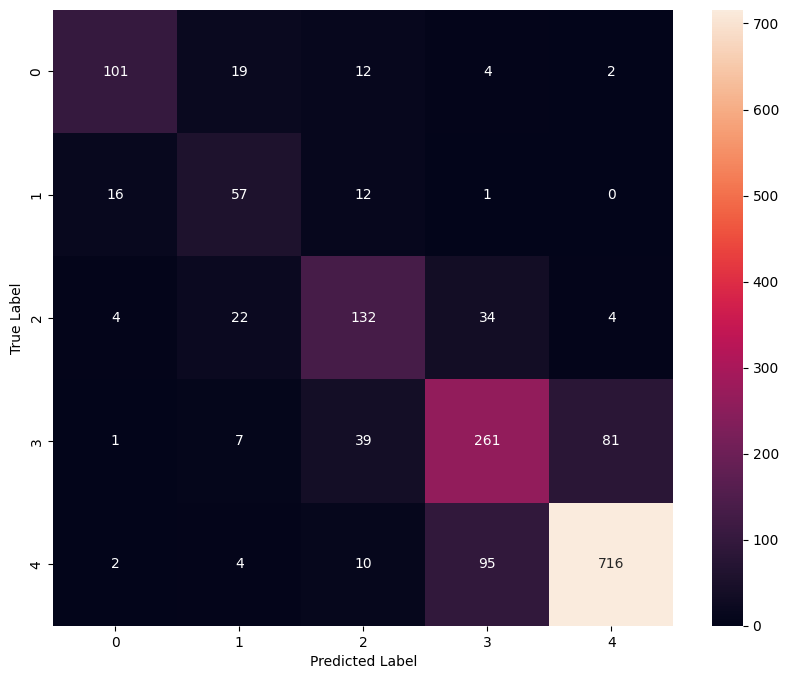

In [357]:
plt.figure(figsize=(10,8))
sns.heatmap(conf_matrix, annot=True, fmt="d")
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()